In [119]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [120]:
datasetPath = "weather_data.csv"
weather_df = pd.read_csv(datasetPath)
weather_df['UV Index'] = pd.to_numeric(weather_df['UV Index'], errors='coerce')
print(weather_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13213 entries, 0 to 13212
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13169 non-null  float64
 1   Humidity              13178 non-null  float64
 2   Wind Speed            13175 non-null  float64
 3   Precipitation (%)     13180 non-null  float64
 4   Cloud Cover           13213 non-null  object 
 5   Atmospheric Pressure  13169 non-null  float64
 6   UV Index              13176 non-null  float64
 7   Season                13213 non-null  object 
 8   Visibility (km)       13166 non-null  float64
 9   Location              13213 non-null  object 
 10  Weather Type          13213 non-null  object 
 11  Irradiance            1333 non-null   float64
dtypes: float64(8), object(4)
memory usage: 1.2+ MB
None


In [121]:
stats = weather_df.describe()
print(stats)

        Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  13169.000000  13178.000000  13175.000000       13180.000000   
mean      19.098507     68.820079      9.814610          53.622281   
std       17.648473     21.247853      7.152796          32.322668   
min     -164.708050     20.000000    -94.138309        -231.786729   
25%        4.000000     57.000000      5.000000          19.000000   
50%       21.000000     70.000000      9.000000          58.000000   
75%       31.000000     84.000000     13.500000          82.000000   
max      154.355435    614.848415     69.469455         467.821581   

       Atmospheric Pressure      UV Index  Visibility (km)   Irradiance  
count          13169.000000  13176.000000     13166.000000  1333.000000  
mean            1004.413619      4.014814         5.454988   702.310397  
std              143.473226      3.892169         3.516754     0.000000  
min            -9196.253993    -12.700931       -54.469352   702.310397  

In [122]:
nullValues = weather_df.isnull().sum()
duplicates = weather_df.duplicated().sum()
samples = weather_df.shape[0]

print(nullValues,nullValues.sum(), duplicates, samples)

Temperature                44
Humidity                   35
Wind Speed                 38
Precipitation (%)          33
Cloud Cover                 0
Atmospheric Pressure       44
UV Index                   37
Season                      0
Visibility (km)            47
Location                    0
Weather Type                0
Irradiance              11880
dtype: int64 12158 13 13213


In [123]:
#detekcia a odstranenie outlierov
def detectOutliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outlier_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure','UV Index', 'Visibility (km)']

for column in outlier_columns:
    outliers = detectOutliers(weather_df, column)
    weather_df = weather_df.drop(outliers.index)
    continue
    plt.figure(figsize=(10,6))

    plt.scatter(weather_df.index, weather_df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=50)

    plt.xlabel(column)
    plt.legend()
    plt.show()



In [124]:
#odstranenie stlpcov v ktorych je vela null hodnot a null hodnot
weather_df_cleaned = weather_df.drop('Irradiance', axis=1)
weather_df_cleaned = weather_df_cleaned.dropna()
weather_df_cleaned = weather_df_cleaned.drop_duplicates()

nullValues = weather_df_cleaned.isnull().sum()
duplicates = weather_df_cleaned.duplicated().sum()
samples = weather_df_cleaned.shape[0]

weather_df.reset_index(drop=True, inplace=True)
one_hot_encoded_columns = ['Cloud Cover', 'Season', 'Location']
weather_df_cleaned_encoded = weather_df_cleaned
for column in one_hot_encoded_columns:
    one_hot_encoded = pd.get_dummies(weather_df_cleaned_encoded[column])
    weather_df_cleaned_encoded = pd.concat([weather_df_cleaned_encoded.drop(columns=column), one_hot_encoded.astype(int)], axis = 1)

label_encoder = LabelEncoder()
weather_df_cleaned_encoded['Weather Type'] = label_encoder.fit_transform(weather_df_cleaned_encoded['Weather Type'])

print(nullValues, nullValues.sum(), duplicates, samples)



Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64 0 0 11300


In [125]:
X = weather_df_cleaned_encoded.drop('Weather Type', axis=1)
Y = weather_df_cleaned_encoded['Weather Type']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size = 0.5, random_state=42)

# plt.figure(figsize=(10,6))

#plt.hist(X_train['Temperature'], bins = 20, color = 'blue', alpha = 0.5)
#plt.show()



X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((7910, 19), (7910,), (1695, 19), (1695,), (1695, 19), (1695,))

In [126]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#X_train_df = pd.DataFrame(X_train)
#plt.hist(X_train_df[1], bins = 20, color = 'blue', alpha = 0.5)
#plt.show()


model accuracy: 0.9634218289085545


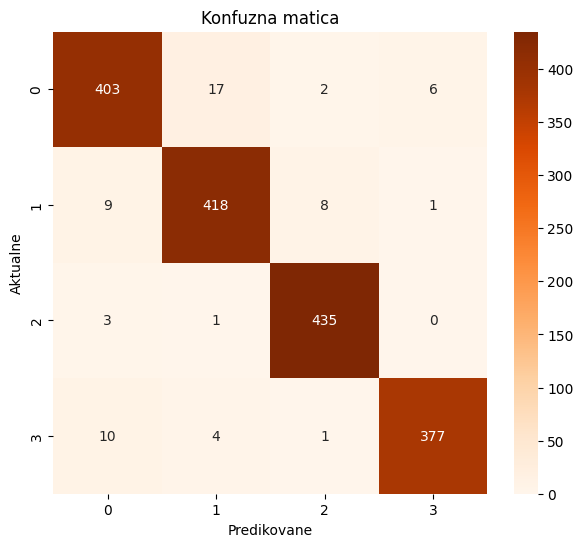

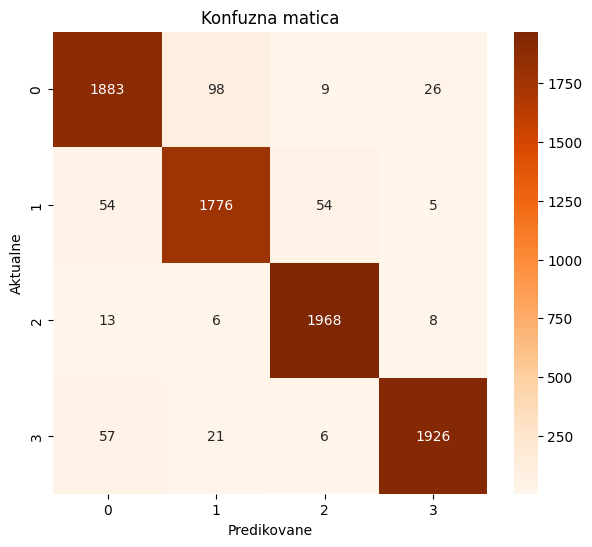

In [127]:
model = LogisticRegression(max_iter=200)
#print(X_train.isnull().sum(), X_train)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzna matica")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

conf_matrix = confusion_matrix(Y_train, y_pred_train)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzna matica")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

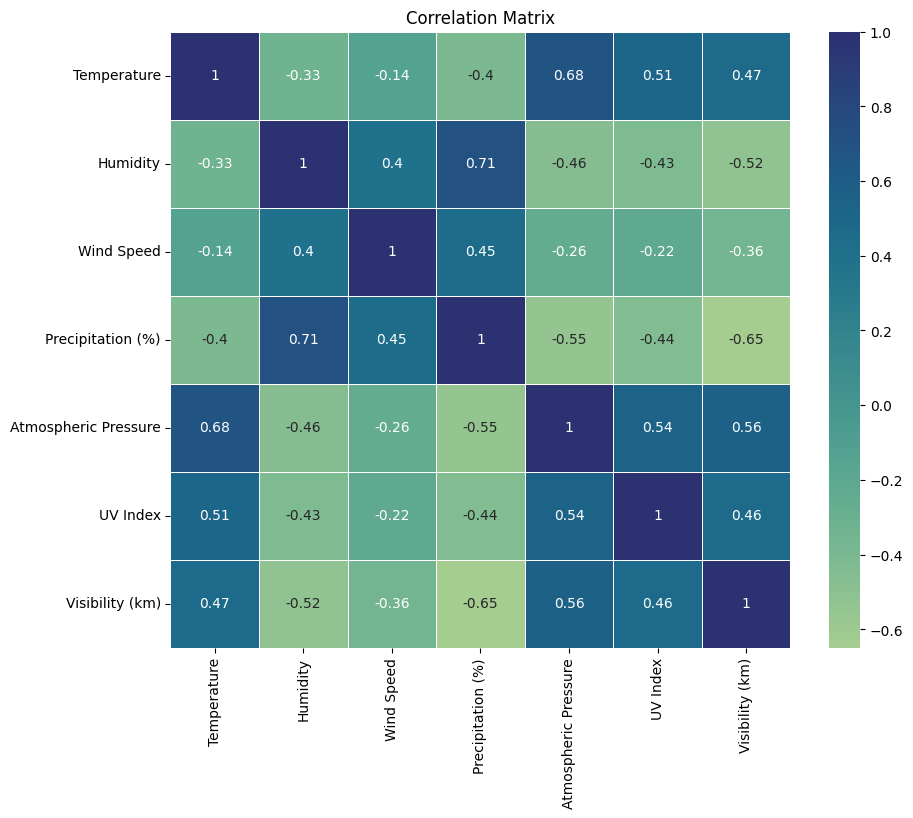

In [128]:
correlation_matrix = weather_df_cleaned.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', linewidths=0.5).set(title="Correlation Matrix")
plt.show()

/tmp/ipykernel_488/3185302277.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(temperature_by_season, x='Cloud Cover', y='Temperature', palette="crest").set(title="Average temperature by cloud cover", ylabel="Average Temperature")


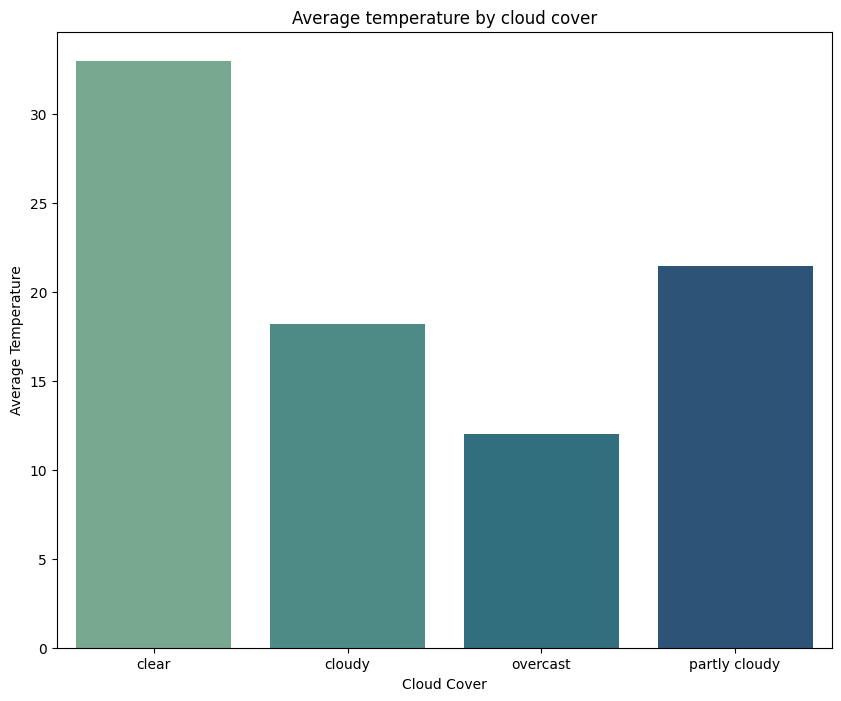

In [129]:
temperature_by_season = weather_df_cleaned.groupby('Cloud Cover')['Temperature'].mean().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(temperature_by_season, x='Cloud Cover', y='Temperature', palette="crest").set(title="Average temperature by cloud cover", ylabel="Average Temperature")
plt.show()

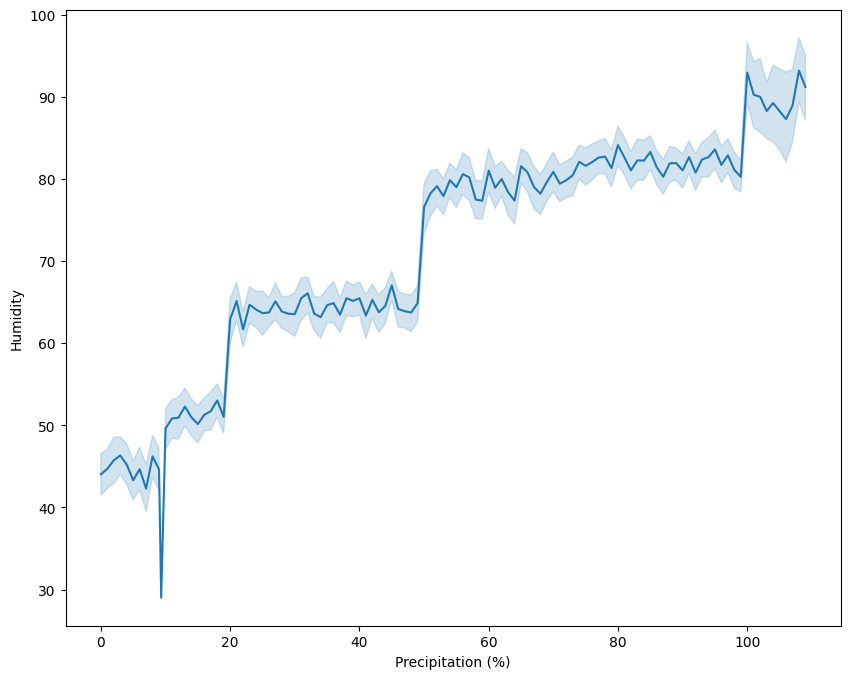

In [130]:
plt.figure(figsize=(10, 8))
sns.lineplot(weather_df_cleaned, x='Precipitation (%)', y='Humidity')
plt.show()

<Figure size 1000x800 with 0 Axes>

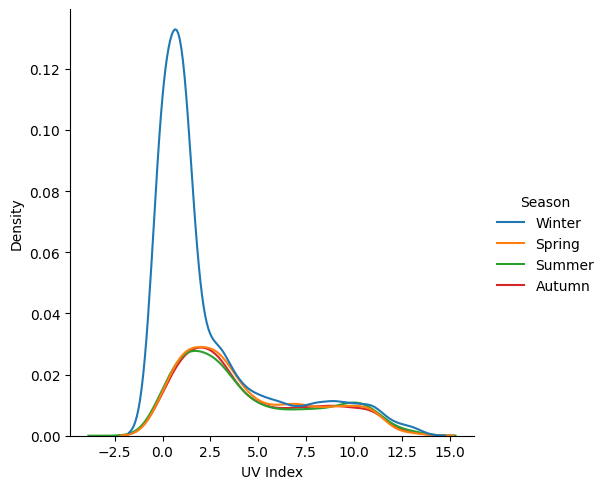

In [131]:
plt.figure(figsize=(10, 8))
sns.displot(weather_df_cleaned, x='UV Index', hue="Season", kind="kde")
plt.show()

<Figure size 2000x800 with 0 Axes>

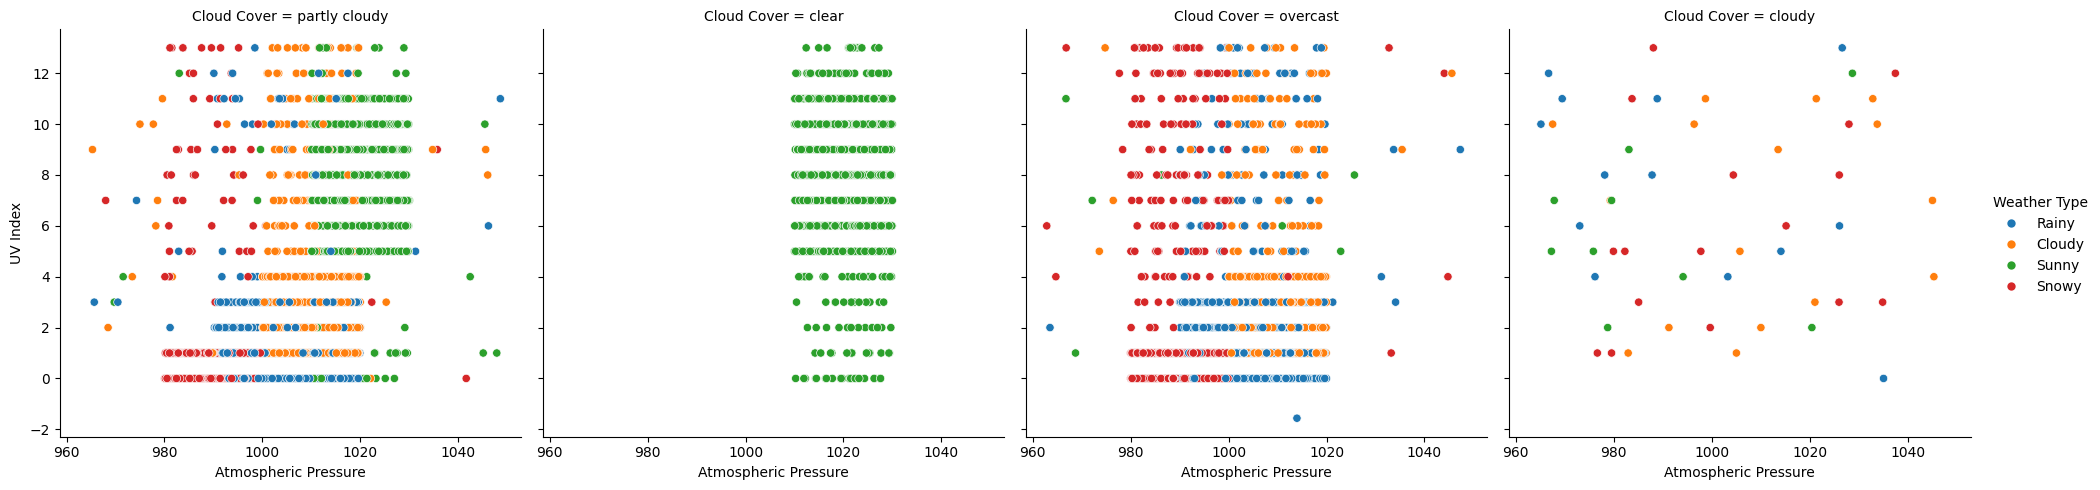

In [132]:
plt.figure(figsize=(20, 8))
sns.relplot(weather_df_cleaned, x='Atmospheric Pressure', y='UV Index', hue="Weather Type", col="Cloud Cover")
plt.show()

In [135]:
one_hot_encoded_columns = ['Cloud Cover', 'Season', 'Location', 'Weather Type']
weather_df_cleaned_encoded = weather_df_cleaned
for column in one_hot_encoded_columns:
    one_hot_encoded = pd.get_dummies(weather_df_cleaned_encoded[column])
    weather_df_cleaned_encoded = pd.concat([weather_df_cleaned_encoded.drop(columns=column), one_hot_encoded.astype(int)], axis = 1)

X = weather_df_cleaned_encoded.drop(['Sunny', 'Rainy', 'Cloudy', 'Snowy'], axis=1)
Y = weather_df_cleaned_encoded[['Sunny', 'Rainy', 'Cloudy', 'Snowy']]

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size = 0.5, random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

import tensorflow as tf
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(16, input_dim=19, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=100, batch_size=5, verbose=1, validation_data=(X_val, Y_val),)

loss, accurracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {accurracy:.4f}')

Epoch 1/100


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1582/1582 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8185 - loss: 0.5032 - val_accuracy: 0.9074 - val_loss: 0.3364
Epoch 2/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8962 - loss: 0.3364 - val_accuracy: 0.7239 - val_loss: 0.6291
Epoch 3/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7253 - loss: 0.5581 - val_accuracy: 0.7251 - val_loss: 0.5850
Epoch 4/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7478 - loss: 0.4837 - val_accuracy: 0.8348 - val_loss: 0.4116
Epoch 5/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8490 - loss: 0.4000 - val_accuracy: 0.7298 - val_loss: 0.5272
Epoch 6/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7284 - loss: 0.4957 - val_accuracy: 0.7198 - val_loss: 0.5429
Epoch 7/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7232 - loss: 0.5279 - val_accuracy: 0.7180 - val_loss: 0.5340
Epoch 8/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7262 - loss: 0.5206 - val_

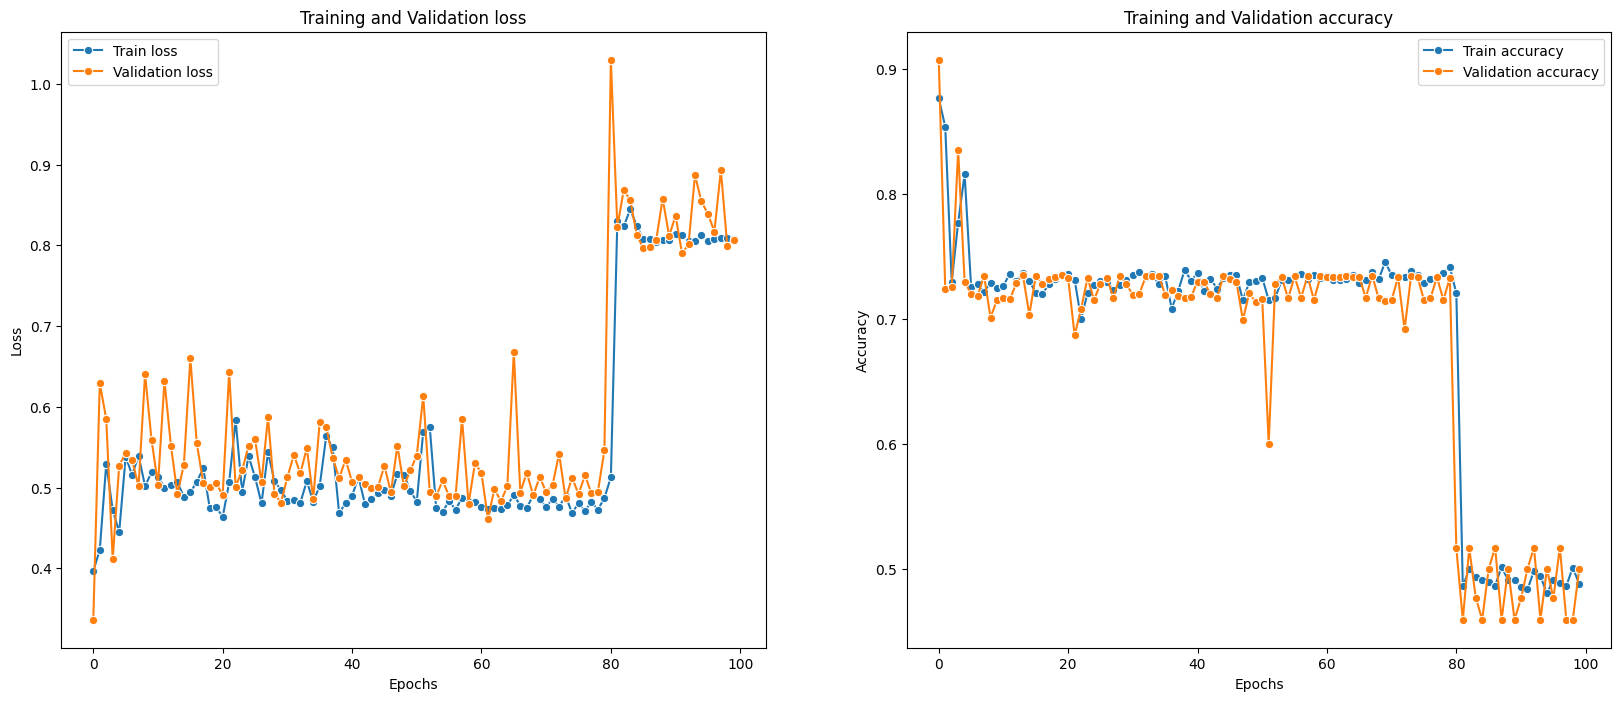

In [143]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label="Train loss", marker="o")
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label="Validation loss", marker="o")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label="Train accuracy", marker="o")
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label="Validation accuracy", marker="o")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()